In [ ]:
import torch
from torchvision import datasets, transforms, models

import torch.nn as nn
import torch.optim as optim

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 100

# Data transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# # Datasets and dataloaders
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, loss function, and optimizer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Files already downloaded and verified
Files already downloaded and verified


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader

'''
folder structure:
    data
        - validataion
            - img00050004.jpg
            - img00050005.jpg
            - img00050007.jpg
            - img00050009.jpg
            - ...
        - training
            - img0000000.jpg
            - img0000001.jpg
            - img0000002.jpg
            - img0000003.jpg
            - img0000004.jpg
            - ...
        - labels.json

        
labels.json:
    [
        {
            "file_path": "img00050004.jpg",
            "file_class": 0
        },
        {
            "file_path": "img00050005.jpg",
            "file_class": 1
        },
        {
            "file_path": "img00050006.jpg",
            "file_class": 1
        },
        {
            "file_path": "img00050007.jpg",
            "file_class": 0
        },
        {
            "file_path": "img00000000.jpg",
            "file_class": 0
        },
        {
            "file_path": "img00000001.jpg",
            "file_class": 1
        }
    ]

'''

class DIFFFibonacciDataset(Dataset):
    def __init__(self, root_dir, label_file, transform=None):
        self.root_dir = root_dir
        self.data_list = os.listdir(root_dir)
        self.transform = transform
        self.label_file = label_file
        self.labels = self.load_labels()

    def load_labels(self):
        with open(self.label_file, 'r') as f:
            labels = json.load(f)
            labels = {label['file_path']: label for label in labels if label['file_path'] in self.data_list}
        return labels

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_list[idx]) 
        image = Image.open(img_name).convert('RGB')
        label = self.labels[self.data_list[idx]]['file_class']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = DIFFFibonacciDataset(root_dir='../data/training', label_file='../data/labels.json', transform=transform)
val_dataset = DIFFFibonacciDataset(root_dir='../data/validation', label_file='../data/labels.json', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

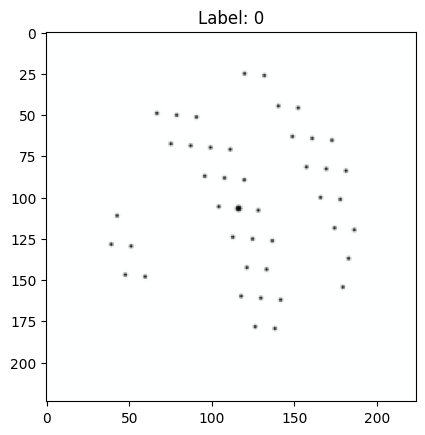

In [54]:
import numpy as np

import matplotlib.pyplot as plt

# Get the first batch of images and labels
images, labels = next(iter(train_loader))

# Select the first image
image = images[0]

# Convert the tensor to a numpy array and transpose the dimensions
image = image.numpy().transpose((1, 2, 0))

# Unnormalize the image
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

# Plot the image
plt.imshow(image)
plt.title(f'Label: {labels[0].item()}')
plt.show()

In [55]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total}%')

print('Training complete')

Epoch [1/100], Loss: 2.3447940349578857
Validation Accuracy: 50.0%
Epoch [2/100], Loss: 0.7947191596031189
Validation Accuracy: 50.0%
Epoch [3/100], Loss: 0.15549369156360626
Validation Accuracy: 100.0%
Epoch [4/100], Loss: 0.017766103148460388
Validation Accuracy: 75.0%
Epoch [5/100], Loss: 0.0021048274356871843
Validation Accuracy: 75.0%
Epoch [6/100], Loss: 0.0006438828422687948
Validation Accuracy: 100.0%
Epoch [7/100], Loss: 0.00030291295843198895
Validation Accuracy: 100.0%
Epoch [8/100], Loss: 0.00017186168406624347
Validation Accuracy: 100.0%
Epoch [9/100], Loss: 0.00010881093476200476
Validation Accuracy: 100.0%
Epoch [10/100], Loss: 7.501898653572425e-05
Validation Accuracy: 100.0%
Epoch [11/100], Loss: 5.61060405743774e-05
Validation Accuracy: 100.0%
Epoch [12/100], Loss: 4.609310417436063e-05
Validation Accuracy: 100.0%
Epoch [13/100], Loss: 4.2417541408212855e-05
Validation Accuracy: 100.0%
Epoch [14/100], Loss: 4.3867359636351466e-05
Validation Accuracy: 100.0%
Epoch [15/

In [59]:
images, labels = next(iter(val_loader))

with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu()

In [60]:
predicted == labels

tensor([True, True, True, True])